# Assignment 3 - Subreddit Classification

This is your third and final assignment of the semester. 

You have a dataset of ~8000 Reddit posts from the following subreddits:
- 'The_Donald',
- 'politics',
- 'ukpolitics', 
- 'relationships', 
- 'conspiracy', 
- 'unitedkingdom', 
- 'explainlikeimfive',
- 'Showerthoughts',
- 'todayilearned',
- 'nottheonion',
- 'rupaulsdragrace'

As with previous assignments, there is a training set and a development set (1000 examples) that you can use. In addition, there is a test set with another 1000 examples which you do not have access to.

### Task
Your task is to **train two models to classify posts according to which subreddit they belong to**. You will notice some of these subreddits are more similar than others. In addition, note that the number of examples from each subreddit varies greatly. You will need to take this *class unbalance* into account. 

You may **not** use additional data for your model. 

Show your work in this notebook, including any data exploration (3 points), pre-processing steps (3 points) and model development (8 points each). Clearly explain any experiments/decisions like you did for assignment 2. 

In addition, do some **error analysis** for each of your models (4 points each). Where/why did your models make mistakes?

### Evaluation
You will be marked based the correctness of your code and the macro F1 of both of your models on the withheld test set.

## Submission Instructions

The assignment is due at **midnight on 3rd May 2023**. Send a zipped folder with your completed notebook as well as the predicitions on the test set to amanda.cercas@unibocconi.it. The email subject line should be "NLP Class 2023 - Assignment 3 \<Student ID\>"

Good luck, and don't...

## Data Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams.update({'font.size': 7, 'font.style': 'normal', 'font.family':'serif'})

In [2]:
df = pd.read_csv('train_subreddit.csv')
df_dev = pd.read_csv('dev_subreddit.csv')
df_test = pd.read_csv('test_subreddit.csv', delimiter=';')

In [3]:
df.shape, df_dev.shape, df_test.shape

((8060, 6), (1022, 6), (1022, 5))

In [4]:
df.head()

,op_id,op_gender,post_id,post_text,subreddit,op_gender_visible
0,thebugjim,M,1320435,Whats kine,todayilearned,False
1,capsulet,W,1189420,What happened??,relationships,False
2,zeMouse,W,1190855,what the fuck dude,relationships,False
3,Xalteox,M,688932,Nope. Both use 1080 by 1200.,explainlikeimfive,False
4,InfinitePossibility8,M,1296373,Everything can if you try hard enough.,The_Donald,False


In [5]:
# Check for missing values
df.isna().sum().sum(), df_dev.isna().sum().sum(), df_test.isna().sum().sum()

(0, 0, 0)

In [6]:
df.loc[:, 'subreddit'].value_counts(normalize = True)

politics             0.285360
todayilearned        0.279032
Showerthoughts       0.091563
relationships        0.086725
The_Donald           0.064144
explainlikeimfive    0.055335
unitedkingdom        0.051365
nottheonion          0.040199
conspiracy           0.035732
rupaulsdragrace      0.010546
Name: subreddit, dtype: float64

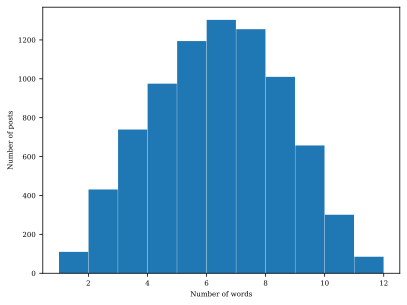

In [7]:
plt.hist(df.loc[:, 'post_text'].apply(lambda x: len(x.split())), bins = 11, rwidth=0.99)
plt.xlabel('Number of words')
plt.ylabel('Number of posts')
plt.show()

The sentences are rather short.

## Data Pre-processing

My take-home from assignment 2 was that data quality matters more than the model you use. For this reason:
- I am using a sentence transformer instead of a simple tokenizer like TF-IDF;
- I am including the op_id variable, even if it's high-dimensional.

Note: we are not using any text preprocessing since the sentence transformer works best on raw text.

### Text tokenization

In [6]:
from sentence_transformers import SentenceTransformer

# Encode the post text with a pretrained embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

df.loc[:, 'post_text_token'] = df.loc[:, 'post_text'].apply(lambda x: model.encode(x))
df_dev.loc[:, 'post_text_token'] = df_dev.loc[:, 'post_text'].apply(lambda x: model.encode(x))
df_test.loc[:, 'post_text_token'] = df_test.loc[:, 'post_text'].apply(lambda x: model.encode(x))

# Convert the list of embeddings into a matrix
embeddings_train = np.vstack(df.loc[:, 'post_text_token'].values)
embeddings_dev = np.vstack(df_dev.loc[:, 'post_text_token'].values)
embeddings_test = np.vstack(df_test.loc[:, 'post_text_token'].values)

In [7]:
np.save('embeddings_train.npy', embeddings_train)
np.save('embeddings_dev.npy', embeddings_dev)
np.save('embeddings_test.npy', embeddings_test)

The following cell performs SVD, but we are not using it since it improves computation at the expense of a loss of information (I will still leave it here).

In [4]:
from sklearn.decomposition import TruncatedSVD

# Initialize SVD with the desired number of components
svd = TruncatedSVD(n_components=200)

# Fit SVD on the training and dev data
#X_train = svd.fit_transform(X_train)
#X_dev = svd.transform(X_dev)
#X_test = svd.transform(X_test)

### Features vectorization

Now we will treat the remaining features and merge all of them together.

Important: following the LightGBM documentation, for high cardinality feature vectors we avoid  one-hot encoding and opt for the normal encoding. We will leave the "op_id" column as a vector, whereas later, for the Neural Network, we will perform a one-hot encoding.

In [4]:
from sklearn.preprocessing import OrdinalEncoder
from scipy.sparse import csr_matrix

# Encode the op_id column
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value= -1, dtype=np.int16)

encoder.fit(df[['op_id']])
op_id = encoder.transform(df[['op_id']])
op_id_dev = encoder.transform(df_dev[['op_id']])
op_id_test = encoder.transform(df_test[['op_id']])

# Create dummies for op_gender and op_gender_visible columns
gender = pd.get_dummies(df.loc[:, ['op_gender']], drop_first=True).values
gender_dev = pd.get_dummies(df_dev.loc[:, ['op_gender']], drop_first=True).values
gender_test = pd.get_dummies(df_test.loc[:, ['op_gender']], drop_first=True).values

gender_visible = pd.get_dummies(df.loc[:, ['op_gender_visible']], drop_first=True).values
gender_visible_dev = pd.get_dummies(df_dev.loc[:, ['op_gender_visible']], drop_first=True).values
gender_visible_test = pd.get_dummies(df_test.loc[:, ['op_gender_visible']], drop_first=True).values

# Stack the features and convert to sparse matrix
X_train = np.hstack([embeddings_train, gender, gender_visible, op_id]) 
X_dev = np.hstack([embeddings_dev, gender_dev, gender_visible_dev, op_id_dev])
X_test = np.hstack([embeddings_test, gender_test, gender_visible_test, op_id_test])

X_train = csr_matrix(X_train)
X_dev = csr_matrix(X_dev)
X_test = csr_matrix(X_test)

Lastly, we specify the labels.

In [5]:
# Create label vectors
y_train = df.loc[:, 'subreddit']
y_dev = df_dev.loc[:, 'subreddit']

## Data Exploration II: visualizing the embeddings

Now that we have vectorized our text, we can visualize it in a two-dimensional space by performing a t-SNE decomposition.

In [8]:
from sklearn.manifold import TSNE

embeddings = np.vstack(df.loc[:, 'post_text_token'].values)

# Perform dimensionality reduction on the embeddings using t-SNE
tsne = TSNE(n_components=2)
embeddings_reduced = tsne.fit_transform(embeddings)

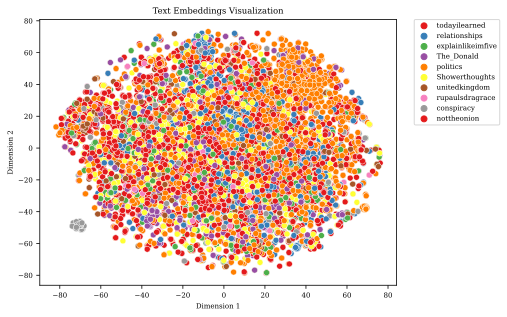

In [9]:
# Create a scatter plot of the embeddings
sns.scatterplot(x=embeddings_reduced[:,0], y=embeddings_reduced[:,1], hue=y_train, legend='full', palette='Set1')
plt.title('Text Embeddings Visualization')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Unfortunately, we can hardly identify any cluster. There is a cloud of points related to the "conspiracy" subreddit (bottom-left), and a concentration of "politics" posts at the top-right. This means that it's hard to predict labels from the text feature alone.

## Preface on modeling

We are going to use the two models that performs the absolute best in Kaggle competitions: LightGBM and Neural Networks.

LightGBM is a fast and efficient gradient boosting framework that uses tree-based learning algorithms. With its high speed and accuracy, it has become a popular choice for modeling in various domains.

Neural Networks represent the state-of-the-art models for any data-related task. They have been proven to be highly versatile and have achieved remarkable results in a wide range of applications. For our task, we will use a simple Feed-Forward network.

## Model 1: LightGBM 

In [6]:
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

### Hyperparameter tuning with cross-validation

We perform a random search through Bayesian optimization, with the aid of Optuna.

In [ ]:
from sklearn.model_selection import cross_val_score
import optuna

# Define the objective function for Optuna
def objective(trial):
    params = {
        'objective': 'multiclass',
        'num_class': 10,
        'class_weight': 'balanced', #this should deal with class imbalance
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'num_leaves': trial.suggest_int('num_leaves', 2, 300),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'n_jobs': -1,
    }
    
    clf = lgb.LGBMClassifier(**params)
    
    # Use cross-validation to evaluate the classifier's performance
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='roc_auc_ovr').mean() #f1_samples
    
    return score

# Create an Optuna study and optimize the objective function
study = optuna.create_study(direction='maximize', study_name='LightGBM_auc')
study.optimize(objective, n_trials=100)

# Print the best hyperparameters and score
print(f"Best score: {study.best_value:.3f}")
print("Best parameters:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

In [13]:
# Saving the study
import joblib
joblib.dump(study, "study.pkl")

['study.pkl']

### Fitting the model and testing it on the dev set

In [10]:
study = joblib.load("study.pkl")

In [10]:
from sklearn.metrics import f1_score

# Set the best hyperparameters obtained from Optuna
params = {
    'objective': 'multiclass',
    'metric' : 'auc_mu',
    'num_class': 10,
    'class_weight' : 'balanced',
    'learning_rate': study.best_params['learning_rate'],
    'num_leaves': study.best_params['num_leaves'],
    'min_child_samples': study.best_params['min_child_samples'],
    'max_depth': study.best_params['max_depth'],
    'colsample_bytree': study.best_params['colsample_bytree'],
    'reg_alpha': study.best_params['reg_alpha'],
    'reg_lambda': study.best_params['reg_lambda'],
    'n_jobs': -1,
}

# Train the model on the training data
clf = lgb.LGBMClassifier(**params)
clf.fit(X_train, y_train)

LGBMClassifier(class_weight='balanced', colsample_bytree=0.27371613471455325,
               learning_rate=0.02248532633236106, max_depth=11, metric='auc_mu',
               min_child_samples=3, num_class=10, num_leaves=82,
               objective='multiclass', reg_alpha=0.25562790265608043,
               reg_lambda=4.792047963625248)

### Error analyis

In [11]:
# Evaluate the model on the dev data
y_pred_lgbm = clf.predict(X_dev)
score = f1_score(y_dev, y_pred_lgbm, average='macro')
print(f"F1 score on dev data: {score:.3f}")

F1 score on dev data: 0.282


The F1 score is decent but not the best.

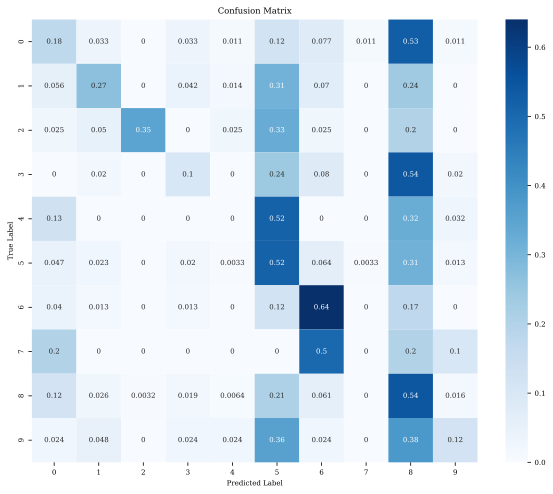

In [12]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix for the dev data
cm = confusion_matrix(y_dev, y_pred_lgbm)

# Normalize the confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Our model performs okay, but we can see that it still suffer from the target imbalance: it tends to predict the classes 5 and 8 more than the others. 

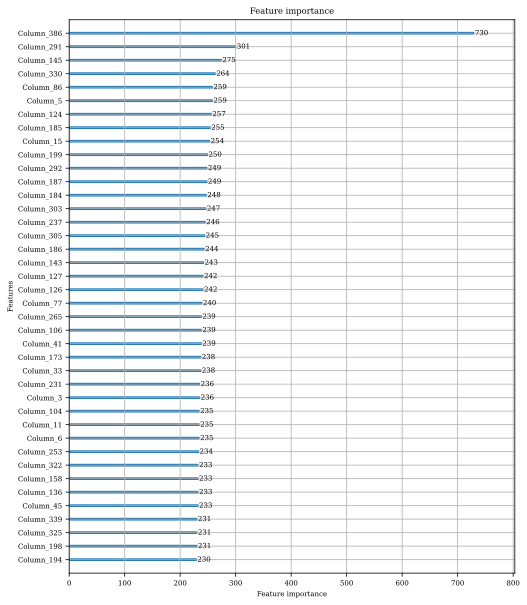

In [13]:
lgb.plot_importance(clf, figsize=(8, 10), max_num_features=40)
plt.show()

Clearly, the most important feature is the id of the original poster (column 386). My hypothesis is that the ordinal encoding of the id variable makes the model a little noisy, because ideally we would like to have a one-hot-endocoding to separate the categories better (not recommended with decision trees). Later we will try one-hot encoding this feature and inputting it into a neural network, to see if it learns more. 

### Prediction

In [14]:
y_pred_test = clf.predict(X_test)
df_test['predictions_lgbm'] = y_pred_test

In [17]:
df_test.drop(columns = 'post_text_token', inplace = True)

## Model 2: Neural Network

In [25]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, f1_score

As previously mentioned, we need to treat carefully the op_id column. Since it cannot remain as a numerically encoded vector, we have to choices:
- eliminate it;
- one-hot encode it.

We opt for the latter, since we don't want to lose information.

In [26]:
# Transforme the matrices to dense format
features = X_train.todense()
features_dev = X_dev.todense()
features_test = X_test.todense()

# Eliminate the op_id column
features = np.delete(features, -1, axis=1)
features_dev = np.delete(features_dev, -1, axis=1)
features_test = np.delete(features_test, -1, axis=1)

# Creat a one-hot encoded version of the id column
id_encoder = OneHotEncoder(categories='auto', handle_unknown='ignore')
id_enc = id_encoder.fit_transform(op_id).todense()
id_enc_dev = id_encoder.transform(op_id_dev).todense()
id_enc_test = id_encoder.transform(op_id_test).todense()

# Stack it with the other features
features = np.hstack([features, id_enc])
features_dev = np.hstack([features_dev, id_enc_dev])
features_test = np.hstack([features_test, id_enc_test])

In [27]:
# Encode the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(y_train).reshape(-1, 1)
labels_dev = label_encoder.transform(y_dev).reshape(-1, 1)

onehot_encoder = OneHotEncoder(sparse_output=False)
labels = onehot_encoder.fit_transform(labels)
labels_dev = onehot_encoder.transform(labels_dev)

In [28]:
# Define the weights for each class
weights_abs = torch.tensor(np.array(labels.sum(axis=0)), dtype=torch.float32).flatten()
weights_inv_abs = weights_abs.sum() / weights_abs
weights_inv_norm = weights_inv_abs / weights_inv_abs.sum()

In [30]:
# Define the dataset class
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        x = torch.tensor(self.features[index], dtype=torch.float32)
        y = torch.tensor(self.labels[index], dtype=torch.float32)
        return x, y

In [31]:
# Specify the model
class Classifier(nn.Module):
    def __init__(self, num_features, num_classes):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(num_features, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [32]:
# This function evauates the model's F1 score
def evaluate_f1(model, dataloader):
    model.eval()
    with torch.no_grad():
        y_true = []
        y_pred = []
        for data_dev, targets_dev in dataloader:
            outputs_dev = model(data_dev).squeeze(1)
            y_true += targets_dev.tolist()
            y_pred += outputs_dev.tolist()

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # Compute F1 score
        f1 = f1_score(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), average='macro')
        
        return f1 

In [64]:
# Define hyperparameters
learning_rate = 0.0003
num_epochs = 30
batch_size = 32

# Initialize model and loss function
model = Classifier(num_features=features.shape[1], num_classes=10)
criterion = nn.CrossEntropyLoss(weight=weights_inv_norm) #weights for the class imbalance
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Prepare data
dataset = CustomDataset(features, labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataset_dev = CustomDataset(features_dev, labels_dev)
dataloader_dev = DataLoader(dataset_dev, batch_size=batch_size, shuffle=False)
dataset_test = CustomDataset(features_test, np.zeros((features_test.shape[0], 10)))
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [65]:
# Train the model
best_f1_iter = 0
best_f1_epoch = 0
patience = 6
train_scores = []
dev_scores = []
best_model_state_dict = None

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(dataloader):
        # Forward pass
        outputs = model(data).squeeze(1)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Evaluate on dev set
        if batch_idx % 100 == 0:
            f1_train = evaluate_f1(model, dataloader)
            f1_dev = evaluate_f1(model, dataloader_dev)

            # Has the score improved?
            if f1_dev > best_f1_iter:
                best_f1_iter = f1_dev
                best_model_state_dict = model.state_dict()
                
            # Save train and dev f1 score
            train_scores.append(f1_train)
            dev_scores.append(f1_dev)

            print('\rEpoch [{}/{}], Step [{}/{}], F1 score train: {:.4f}, F1 score dev: {:.4f}'.format(
                epoch+1, num_epochs, batch_idx+1, len(dataloader), f1_train, f1_dev), end='')
                
    # Early stopping
    if best_f1_iter > best_f1_epoch:
        best_f1_epoch = best_f1_iter
        patience = 7
    else:
        patience -= 1
                
    if patience < 1:
        print('\nNo improvement for 6 epochs, early stopping.')
        print(f'Best F1 score: {best_f1_epoch:.4f}')
        break

# Load the best model state dictionary
if best_model_state_dict:
    model.load_state_dict(best_model_state_dict)

Epoch [26/30], Step [201/252], F1 score train: 0.9414, F1 score dev: 0.5339
No improvement for 6 epochs, early stopping.
Best F1 score: 0.5486


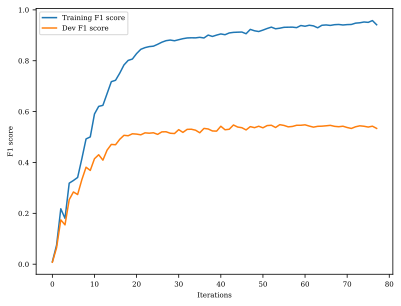

In [66]:
# Plotting the scores
plt.plot(train_scores, label='Training F1 score')
plt.plot(dev_scores, label='Dev F1 score')
plt.xlabel('Iterations')
plt.ylabel('F1 score')
plt.legend()
plt.show()

### Error analysis

In [67]:
model.eval()
with torch.no_grad():
    y_true = []
    y_pred_nn = []
    for data, targets in dataloader_dev:
        outputs = model(data).squeeze(1)
        y_true += targets.tolist()
        y_pred_nn += outputs.tolist()

    y_true = np.array(y_true)
    y_pred_nn = np.array(y_pred_nn)

    # Compute ROC AUC score
    auc = roc_auc_score(y_true, y_pred_nn, multi_class='ovr')

    # Reduce the outputs from one-hot to single label
    y_true = np.argmax(y_true, axis=1)
    y_pred_nn = np.argmax(y_pred_nn, axis=1)

    # Compute macro F1 score
    f1 = f1_score(y_true, y_pred_nn, average='macro')

    print('Mean AUC of the model on the test data: {:.4f}'.format(auc))
    print('Mean F1 score of the model on the test data: {:.4f}'.format(f1))

Mean AUC of the model on the test data: 0.8068
Mean F1 score of the model on the test data: 0.5480


The result is mind-blowing! It's around double the performance of the GB model. I feel it's because of the op_id better encoding.

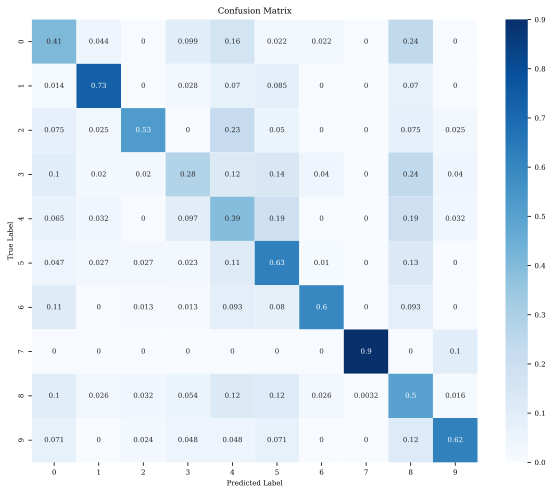

In [68]:
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix for the dev data
cm = confusion_matrix(y_true, y_pred_nn)

# Normalize the confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

The classes appear to be much better separated.

Let's distinguish between observations with the op_id in the training set and without. 

In [69]:
mask = (op_id_dev == -1).ravel()

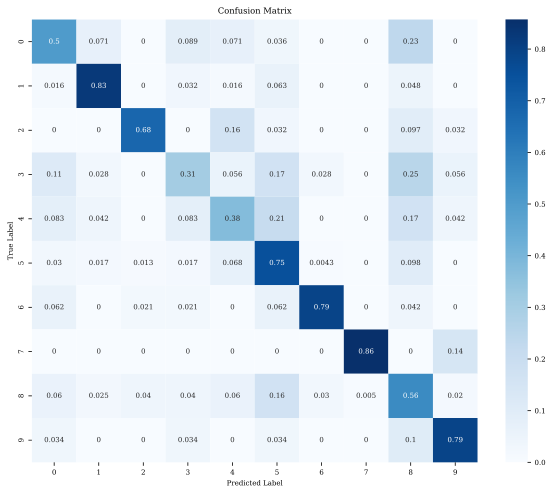

In [70]:
# Compute the confusion matrix for the dev data with insample id
cm = confusion_matrix(y_true[~mask], y_pred_nn[~mask])

# Normalize the confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

When the op_id has been seen in the training set, the neural network performance is superior compared to the average.

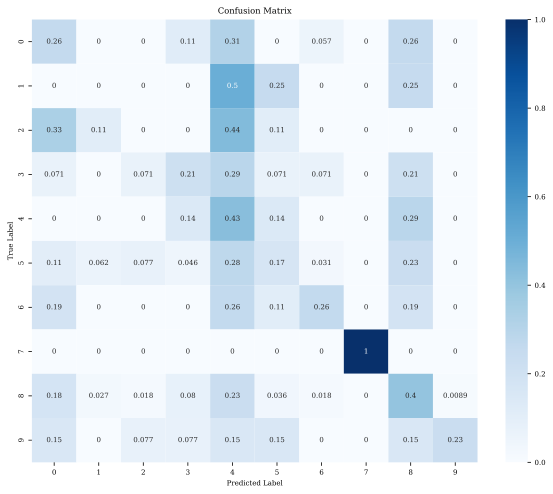

In [71]:
# Compute the confusion matrix for the dev data without insample id
cm = confusion_matrix(y_true[mask], y_pred_nn[mask])

# Normalize the confusion matrix
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Conversely, when the op_id is not available, our model struggles to make predictions only based on the post text, op_gender and op_gender_visible features.

As we can see, the id of the original poster is a significant predictor of the subreddit: rightly so, since usually people tend to browse/post in the same subreddits. Without this feature, our classifier is much weaker.

### Prediction

In [72]:
# Predict the test labels
model.eval()
with torch.no_grad():
    y_pred_nn = []
    for data, targets in dataloader_test:
        outputs = model(data).squeeze(1)
        y_pred_nn += outputs.tolist()

    y_pred_nn = np.array(y_pred_nn)

    # Reduce the outputs from one-hot to single label
    y_pred_nn = np.argmax(y_pred_nn, axis=1)

In [73]:
# Decode the labels
y_pred_nn = label_encoder.inverse_transform(y_pred_nn)
df_test['predictions_nn'] = y_pred_nn

In [74]:
#df_test.to_csv('predictions.csv', index=False)